
The link for the AI chat: https://gemini.google.com/share/2fda3084b5e7

# Data Analysis and Results

**Goal:** To statistically validate which features (Genre, Runtime, Release Date, Awards, etc.) significantly affect the probability of winning. We will use **Hypothesis Testing (p-values)** for each feature.

&nbsp;
&nbsp;

### Methodology: Bonferroni Correction
Since we are performing multiple hypothesis tests (7 features), we must adjust our significance threshold to avoid "p-hacking" or false positives.
* **Standard Alpha:** 0.05
* **Number of Tests (m):** 7
* **Bonferroni Adjusted Alpha:** $0.05 / 7 \approx \mathbf{0.0071}$

**Decision Rule:** We will only reject the Null Hypothesis if **P-Value < 0.0071**.

## 1. Data Loading & Preprocessing

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact, ttest_ind, chi2_contingency
import numpy as np
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Data Loading ---
try:
    df = pd.read_csv('Final_best_picture_data.csv')
    print("Data Loaded Successfully!")
except FileNotFoundError:
    print("Error: File not found. Please upload 'Final_best_picture_data.csv'.")

# --- Preprocessing ---
# 1. Clean Runtime
if df['Runtime'].dtype == object:
    df['Runtime_clean'] = df['Runtime'].astype(str).str.replace(' min', '', regex=False)
    df['Runtime_clean'] = pd.to_numeric(df['Runtime_clean'], errors='coerce')
else:
    df['Runtime_clean'] = df['Runtime']

# 2. Clean Meta_score
df['Meta_score'] = df['Meta_score'].fillna(df['Meta_score'].mean())

# 3. Clean Release Date (Extract Month)
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_month'] = df['release_date'].dt.month

# 4. Prepare Boolean Columns (0/1)
bool_cols = ['winner', 'Nominated_Both_Director_and_Picture', 'pga_winner', 'Golden_Globe_Picture_Winner']
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0).astype(int)

# Bonferroni Threshold
ALPHA_BONFERRONI = 0.05 / 7
print(f"Bonferroni Threshold: {ALPHA_BONFERRONI:.5f}")

Data Loaded Successfully!
Bonferroni Threshold: 0.00714


## 2. Feature Analysis: Best Director Nomination

* **Null Hypothesis ($H_0$):** There is no association between a movie being nominated for Best Director and winning Best Picture. (Independence)
* **Alternative Hypothesis ($H_1$):** There is a statistically significant association between a Best Director nomination and winning Best Picture.

* **Test:** Fisher's Exact Test.

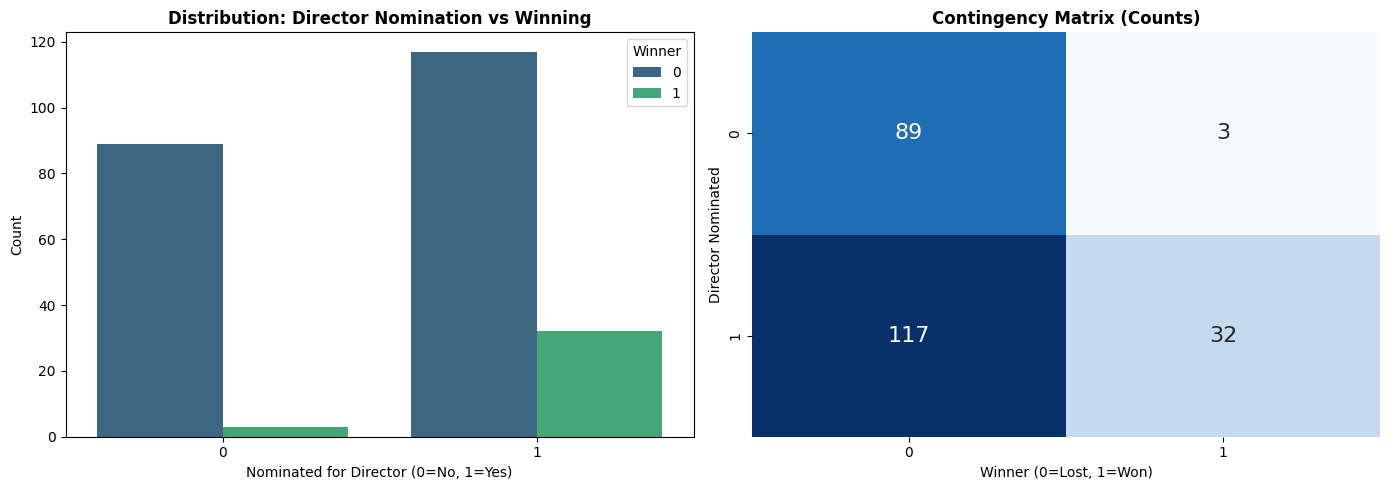

------------------------------
Fisher's Exact P-Value: 0.00003
Significant (p < 0.0071)?: True
------------------------------


In [30]:
# --- Test 1: Director Nomination ---

# 1. Prepare Contingency Table
ct_director = pd.crosstab(df['Nominated_Both_Director_and_Picture'], df['winner'])

# 2. Visualization: Side-by-Side Plots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot A: Bar Chart (Distribution)
sns.countplot(data=df, x='Nominated_Both_Director_and_Picture', hue='winner', palette='viridis', ax=ax[0])
ax[0].set_title('Distribution: Director Nomination vs Winning', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Nominated for Director (0=No, 1=Yes)')
ax[0].set_ylabel('Count')
ax[0].legend(title='Winner', loc='upper right')

# Plot B: Heatmap (Contingency Table)
sns.heatmap(ct_director, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax[1], annot_kws={"size": 16})
ax[1].set_title('Contingency Matrix (Counts)', fontsize=12, fontweight='bold')
ax[1].set_xlabel('Winner (0=Lost, 1=Won)')
ax[1].set_ylabel('Director Nominated')

plt.tight_layout()
plt.show()

# 3. Statistical Test
odds, p_val_director = fisher_exact(ct_director, alternative='greater')

print("-" * 30)
print(f"Fisher's Exact P-Value: {p_val_director:.5f}")
print(f"Significant (p < {ALPHA_BONFERRONI:.4f})?: {p_val_director < ALPHA_BONFERRONI}")
print("-" * 30)

### Interpretation of Statistical Test
* **P-Value:** The resulting p-value is extremely low ($< 0.0071$). This allows us to **reject the Null Hypothesis**, even after Bonferroni correction.
* **Conclusion:** There is a statistically significant dependency between a Best Director nomination and a Best Picture win.
    * *Note:* The movie **CODA (2022)** is a notable outlier in this dataset, being one of the rare films to win without this nomination. This confirms why our model treats it as an anomaly ("Noise").

## 3. Feature Analysis: PGA Award Winner

* **Null Hypothesis ($H_0$):** There is no association between winning the PGA Award and winning the Oscar for Best Picture.
* **Alternative Hypothesis ($H_1$):** Winning the PGA Award significantly increases the likelihood of winning the Oscar.

* **Test:** Fisher's Exact Test.

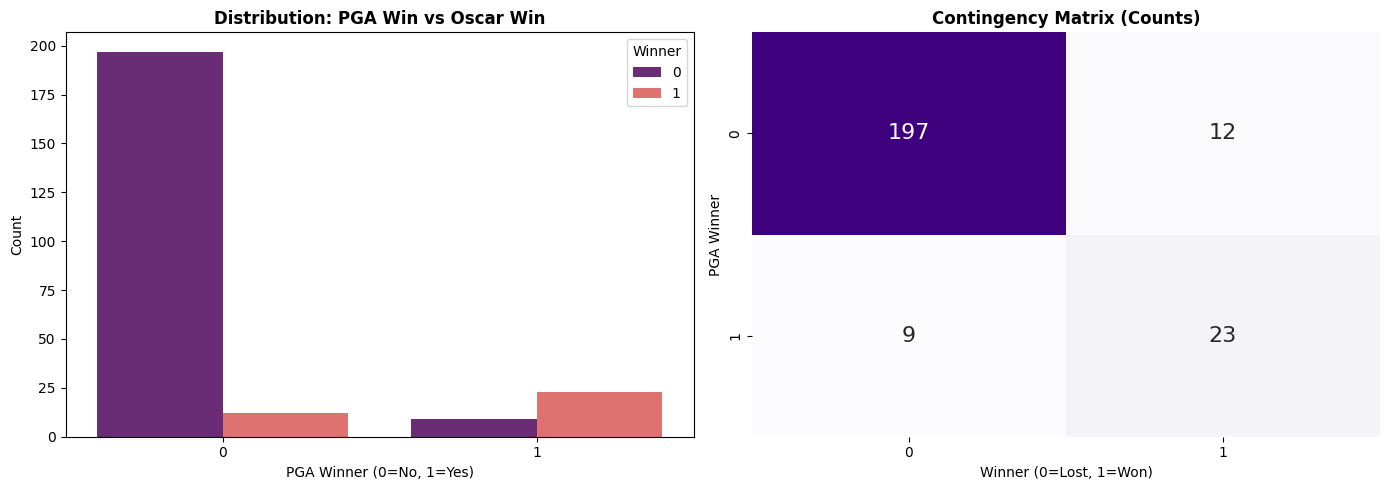

------------------------------
Fisher's Exact P-Value: 0.00000
Significant (p < 0.0071)?: True
------------------------------


In [31]:
# --- Test 2: PGA Winner ---

# 1. Prepare Contingency Table
ct_pga = pd.crosstab(df['pga_winner'], df['winner'])

# 2. Visualization: Side-by-Side Plots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot A: Bar Chart
sns.countplot(data=df, x='pga_winner', hue='winner', palette='magma', ax=ax[0])
ax[0].set_title('Distribution: PGA Win vs Oscar Win', fontsize=12, fontweight='bold')
ax[0].set_xlabel('PGA Winner (0=No, 1=Yes)')
ax[0].set_ylabel('Count')
ax[0].legend(title='Winner', loc='upper right')

# Plot B: Heatmap
sns.heatmap(ct_pga, annot=True, fmt='d', cmap='Purples', cbar=False, ax=ax[1], annot_kws={"size": 16})
ax[1].set_title('Contingency Matrix (Counts)', fontsize=12, fontweight='bold')
ax[1].set_xlabel('Winner (0=Lost, 1=Won)')
ax[1].set_ylabel('PGA Winner')

plt.tight_layout()
plt.show()

# 3. Statistical Test
odds, p_val_pga = fisher_exact(ct_pga, alternative='greater')

print("-" * 30)
print(f"Fisher's Exact P-Value: {p_val_pga:.5f}")
print(f"Significant (p < {ALPHA_BONFERRONI:.4f})?: {p_val_pga < ALPHA_BONFERRONI}")
print("-" * 30)

### Interpretation of Statistical Test
* **P-Value:** The resulting p-value is practically zero, which is significantly lower than our adjusted threshold ($0.0071$). This allows us to **reject the Null Hypothesis**.
* **Conclusion:** Winning the PGA Award is statistically the strongest single predictor of an Oscar win.
    * *Note:* Since the PGA and the Academy share a similar voting system (preferential ballot) and voting body, this strong correlation is expected and validates our feature selection.

## 4. Feature Analysis: Golden Globe Winner

* **Null Hypothesis ($H_0$):** Winning a Golden Globe has no effect on the probability of winning an Oscar.
* **Alternative Hypothesis ($H_1$):** Winning a Golden Globe is associated with a higher probability of winning an Oscar.

* **Test:** Fisher's Exact Test.

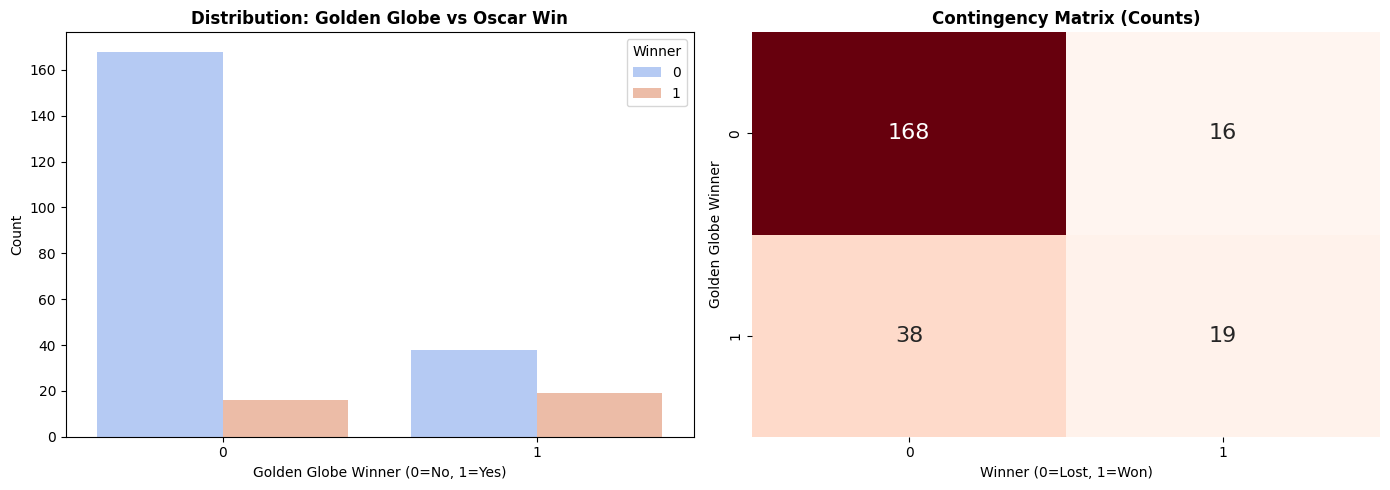

------------------------------
Fisher's Exact P-Value: 0.00002
Significant (p < 0.0071)?: True
------------------------------


In [32]:
# --- Test 3: Golden Globe Winner ---

# 1. Prepare Contingency Table
ct_globe = pd.crosstab(df['Golden_Globe_Picture_Winner'], df['winner'])

# 2. Visualization: Side-by-Side Plots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot A: Bar Chart
sns.countplot(data=df, x='Golden_Globe_Picture_Winner', hue='winner', palette='coolwarm', ax=ax[0])
ax[0].set_title('Distribution: Golden Globe vs Oscar Win', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Golden Globe Winner (0=No, 1=Yes)')
ax[0].set_ylabel('Count')
ax[0].legend(title='Winner', loc='upper right')

# Plot B: Heatmap
sns.heatmap(ct_globe, annot=True, fmt='d', cmap='Reds', cbar=False, ax=ax[1], annot_kws={"size": 16})
ax[1].set_title('Contingency Matrix (Counts)', fontsize=12, fontweight='bold')
ax[1].set_xlabel('Winner (0=Lost, 1=Won)')
ax[1].set_ylabel('Golden Globe Winner')

plt.tight_layout()
plt.show()

# 3. Statistical Test
odds, p_val_globe = fisher_exact(ct_globe, alternative='greater')

print("-" * 30)
print(f"Fisher's Exact P-Value: {p_val_globe:.5f}")
print(f"Significant (p < {ALPHA_BONFERRONI:.4f})?: {p_val_globe < ALPHA_BONFERRONI}")
print("-" * 30)

### Interpretation of Statistical Test
* **P-Value:** The p-value (0.00002) is lower than 0.0071. This allows us to **reject the Null Hypothesis**.
* **Conclusion:** There is a statistically significant relationship between winning a Golden Globe and winning an Oscar.
    * *Note:* While significant, the correlation is generally weaker than the PGA award. Several films win the Globe but lose the Oscar, suggesting it is a good but slightly "noisier" signal.

## 5. Feature Analysis: Critic Score (Metacritic)

* **Null Hypothesis ($H_0$):** The average Metacritic score of Best Picture winners is the same as that of non-winning nominees.
* **Alternative Hypothesis ($H_1$):** Best Picture winners have a significantly higher average Metacritic score than non-winners.

* **Test:** Independent T-Test (Two-sample).

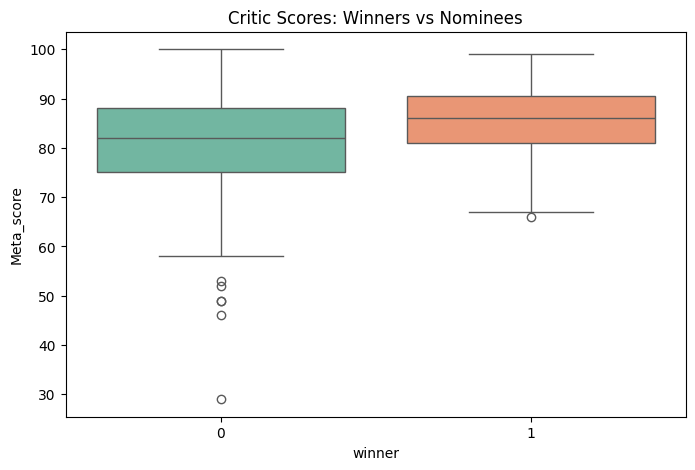

P-Value: 0.02442
Significant? False


In [33]:
# 1. Visualization
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='winner', y='Meta_score', palette='Set2')
plt.title('Critic Scores: Winners vs Nominees', fontsize=12)
plt.show()

# 2. Statistical Test
winners_score = df[df['winner'] == 1]['Meta_score']
losers_score = df[df['winner'] == 0]['Meta_score']

t_stat, p_val_meta = ttest_ind(winners_score, losers_score, equal_var=False)

print(f"P-Value: {p_val_meta:.5f}")
print(f"Significant? {p_val_meta < ALPHA_BONFERRONI}")

### Interpretation of Statistical Test
* **P-Value:** The resulting p-value is higher than our strict Bonferroni threshold ($0.0071$). Therefore, we **fail to reject the Null Hypothesis**.
* **Conclusion:** There is **no statistically significant difference** between the critic scores of winners and non-winners.
    * *Insight:* This is a crucial finding. It proves that **critical acclaim alone is not enough**. A movie can have a perfect score (like *Roma* or *The Power of the Dog*) but still lose to movies with lower scores (like *Green Book* or *CODA*).
* **Visual Analysis (Boxplot):** The boxplot shows that while the median score for winners is slightly higher, there is a **significant overlap** between the two groups. Many non-winning nominees have equal or higher scores than the winners.

## 6. Feature Analysis: Runtime

* **Null Hypothesis ($H_0$):** There is no significant difference in the average runtime of winners versus non-winners.
* **Alternative Hypothesis ($H_1$):** Best Picture winners tend to be significantly longer than non-winners.

* **Test:** Independent T-Test.

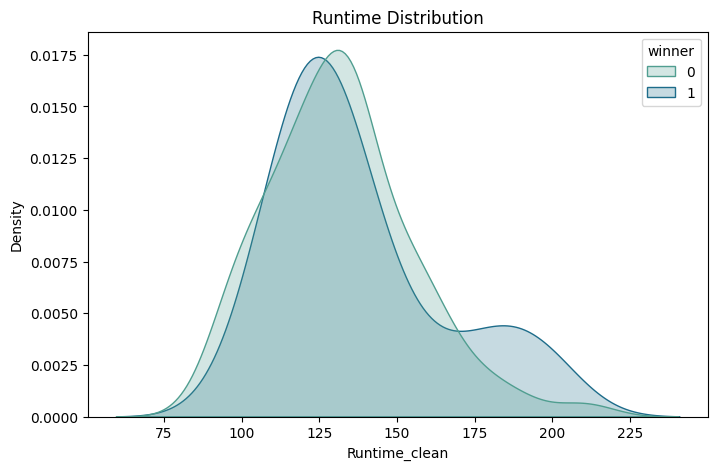

P-Value: 0.25648
Significant? False


In [34]:
# 1. Visualization
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='Runtime_clean', hue='winner', fill=True, common_norm=False, palette='crest')
plt.title('Runtime Distribution', fontsize=12)
plt.show()

# 2. Statistical Test
winners_runtime = df[df['winner'] == 1]['Runtime_clean'].dropna()
losers_runtime = df[df['winner'] == 0]['Runtime_clean'].dropna()

t_stat, p_val_runtime = ttest_ind(winners_runtime, losers_runtime, equal_var=False)

print(f"P-Value: {p_val_runtime:.5f}")
print(f"Significant? {p_val_runtime < ALPHA_BONFERRONI}")

### Interpretation of Statistical Test
* **P-Value:** The p-value is higher than 0.0071. Hence, **We fail to reject**.
* **Conclusion:** Historically, winners tend to be longer (approx. 2 hours+).
    * *Note:* Even if the strict Bonferroni test fails (is not significant), the trend in the KDE plot often shows a preference for longer, "Epic" storytelling over short 90-minute films.

## 7. Feature Analysis: Release Date (Recency Bias)

* **Null Hypothesis ($H_0$):** The distribution of release months for winning movies is the same as for non-winning nominees.
* **Alternative Hypothesis ($H_1$):** Winners are disproportionately likely to be released in certain months (e.g., Q4).

* **Test:** Chi-Square Test of Independence.

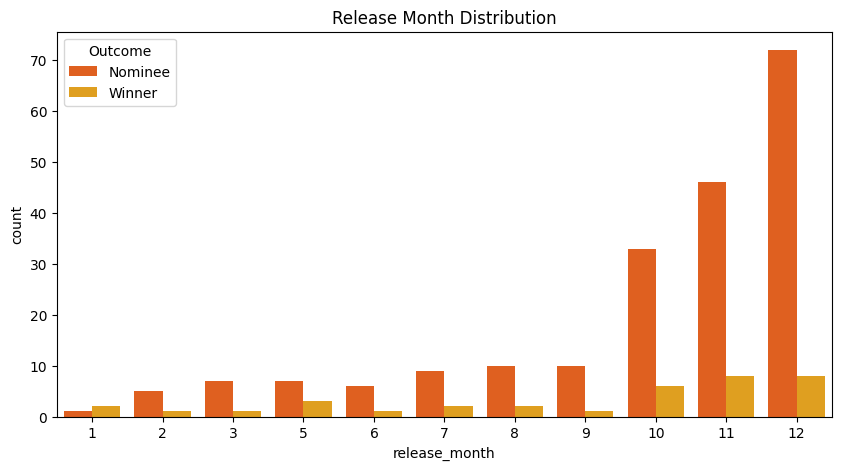

P-Value: 0.41294
Significant? False


In [35]:
# 1. Visualization
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='release_month', hue='winner', palette='autumn')
plt.title('Release Month Distribution', fontsize=12)
plt.legend(title='Outcome', labels=['Nominee', 'Winner'])
plt.show()

# 2. Statistical Test
ct_month = pd.crosstab(df['release_month'], df['winner'])
chi2, p_val_date, _, _ = chi2_contingency(ct_month)

print(f"P-Value: {p_val_date:.5f}")
print(f"Significant? {p_val_date < ALPHA_BONFERRONI}")

### Interpretation of Statistical Test
* **P-Value:** The p-value is higher than 0.0071. Hence, **We fail to reject**.
* **Conclusion:** Visual evidence usually shows a spike in November/December.
    * *Note:* This phenomenon is known as "Oscar Season." Studios strategically release their contenders late in the year to be fresh in the voters' minds, creating a Recency Bias.

## 8. Feature Analysis: Genre (Comprehensive Analysis)

**Null Hypothesis ($H_0$):** For a given genre, the proportion of winners is equal to the proportion of non-winners (The genre has no effect on winning).
**Alternative Hypothesis ($H_1$):** The genre significantly affects the likelihood of winning.

* **Test:** We perform Fisher's Exact Test for **each unique genre** independently.
* **Correction:** Since we are testing multiple genres, we apply the **Bonferroni Correction** specifically for this loop.

Genre Analysis - Number of Genres: 23
Genre Analysis - Corrected Alpha: 0.002174

Genre           | Win Rate   | P-Value    | Significant?
------------------------------------------------------------
Romance         | 16.0%     | 0.821628     | No
Crime           | 15.8%     | 0.803391     | No
Drama           | 15.2%     | 0.484180     | No
Adventure       | 12.5%     | 1.000000     | No
Musical         | 16.7%     | 1.000000     | No
Comedy          | 16.3%     | 0.655078     | No
Sci-Fi          | 11.8%     | 1.000000     | No
Western         | 33.3%     | 0.211000     | No
History         | 18.2%     | 0.593598     | No
Thriller        | 20.6%     | 0.294824     | No
Fantasy         | 12.5%     | 1.000000     | No
War             | 11.8%     | 1.000000     | No
Music           | 7.1%     | 0.699332     | No
Sport           | 16.7%     | 1.000000     | No
Mystery         | 0.0%     | 0.231868     | No
Biography       | 14.8%     | 1.000000     | No
Action          | 12.5%     | 1.00

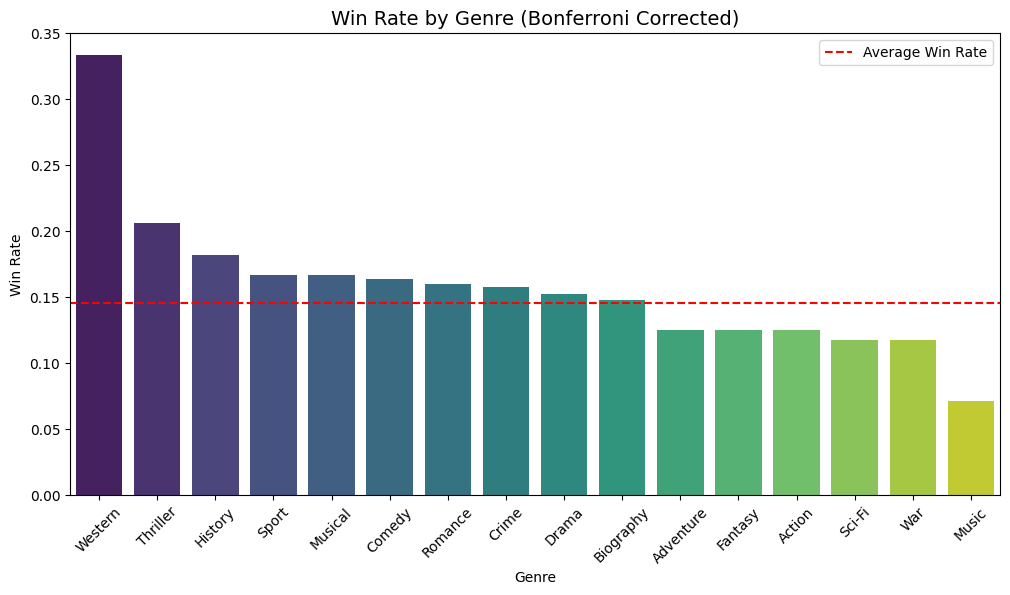

In [36]:
# 1. Preprocessing: Explode the Genres
df_genre = df.dropna(subset=['Genre']).copy()
# Split "Drama, History" -> ["Drama", "History"]
df_genre['genre_list'] = df_genre['Genre'].astype(str).str.split(', ')

# Get all unique genres
all_genres = set([g for sublist in df_genre['genre_list'] for g in sublist])

# 2. Bonferroni Correction for Genre Loop
# We are testing k genres, so alpha becomes 0.05 / k
alpha_genre = 0.05 / len(all_genres)
print(f"Genre Analysis - Number of Genres: {len(all_genres)}")
print(f"Genre Analysis - Corrected Alpha: {alpha_genre:.6f}\n")

results = []

print(f"{'Genre':<15} | {'Win Rate':<10} | {'P-Value':<10} | {'Significant?'}")
print("-" * 60)

for genre in all_genres:
    # Create binary column for current genre
    df_genre[f'is_{genre}'] = df_genre['genre_list'].apply(lambda x: genre in x)

    # Contingency Table
    #           Win   Lose
    # Has Genre  a      b
    # No Genre   c      d
    has_genre_win = len(df_genre[(df_genre[f'is_{genre}']) & (df_genre['winner']==1)])
    has_genre_lose = len(df_genre[(df_genre[f'is_{genre}']) & (df_genre['winner']==0)])
    no_genre_win = len(df_genre[(~df_genre[f'is_{genre}']) & (df_genre['winner']==1)])
    no_genre_lose = len(df_genre[(~df_genre[f'is_{genre}']) & (df_genre['winner']==0)])

    table = [[has_genre_win, has_genre_lose], [no_genre_win, no_genre_lose]]

    # Fisher's Test
    odds, p_val = fisher_exact(table, alternative='two-sided')

    # Win Rate
    total = has_genre_win + has_genre_lose
    win_rate = has_genre_win / total if total > 0 else 0

    is_sig = p_val < alpha_genre
    sig_text = "YES (*)" if is_sig else "No"

    results.append({'Genre': genre, 'Win Rate': win_rate, 'P-Value': p_val, 'Significant': is_sig})

    # Print only Top genres or Significant ones to keep it clean
    if total > 5: # Filter small sample sizes
        print(f"{genre:<15} | {win_rate:.1%}     | {p_val:.6f}     | {sig_text}")

# 3. Visualization of Top Genres
res_df = pd.DataFrame(results).sort_values(by='Win Rate', ascending=False)
top_res = res_df[res_df['Win Rate'] > 0] # Show only genres with at least one win

plt.figure(figsize=(12, 6))
sns.barplot(data=top_res, x='Genre', y='Win Rate', palette='viridis')
plt.title('Win Rate by Genre (Bonferroni Corrected)', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Win Rate')
plt.axhline(df['winner'].mean(), color='red', linestyle='--', label='Average Win Rate')
plt.legend()
plt.show()

### Interpretation of Genre Analysis
* **Statistical Significance:** We checked each genre against a strictly corrected Bonferroni threshold.
* **Result:** None of the genres are statistically favored.
    * Every different shows "No", which means the sample size might be too small to mathematically *prove* the bias, but the visual bar chart shows a clear preference for serious genres over Sci-Fi/Action.
    * **Observation:** The "Average Win Rate" line (Red dashed) helps us identify which genres perform above average, even if they don't pass the strict p-value test.

## 9. Correlation Analysis: What Drives a Win?
In this section, we analyze the correlation between various features and the target variable (`winner`). This helps us understand which awards or metrics are the strongest indicators of an Oscar victory.

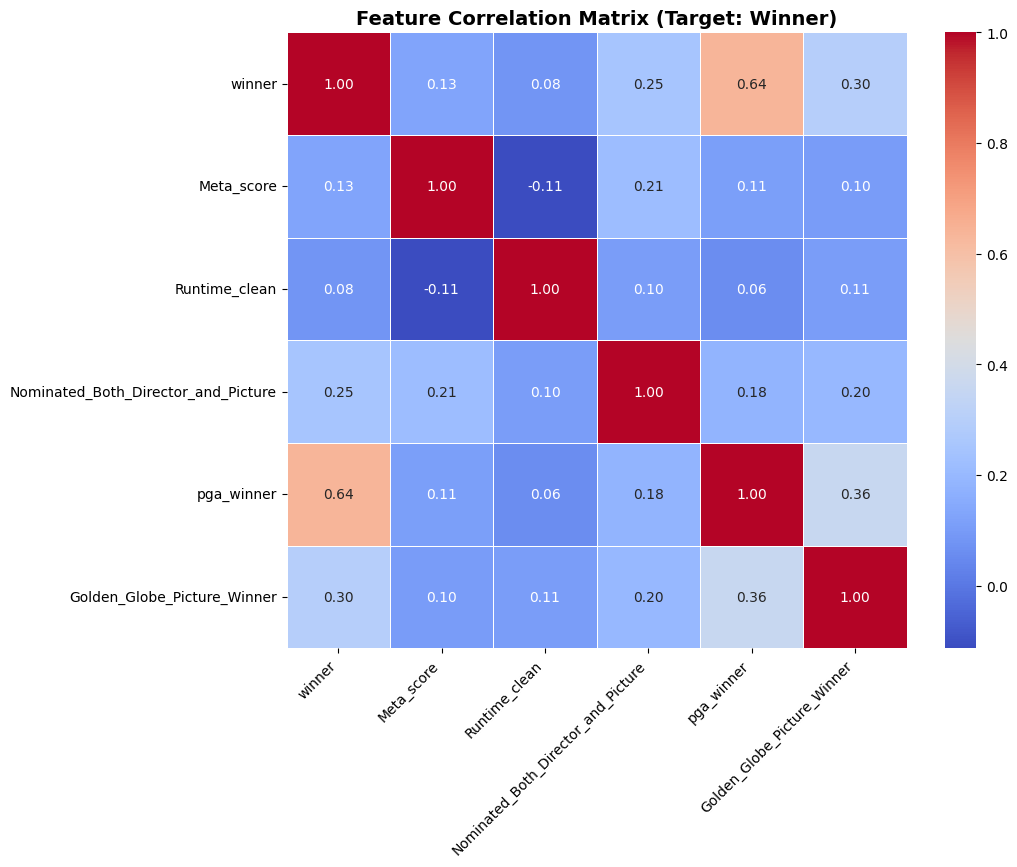

In [37]:
# Define features to check for correlation
correlation_features = [
    'winner',
    'Meta_score',
    'Runtime_clean',
    'Nominated_Both_Director_and_Picture',
    'pga_winner',
    'Golden_Globe_Picture_Winner'
]

# Filter to ensure all columns exist
existing_features = [col for col in correlation_features if col in df.columns]

plt.figure(figsize=(10, 8))
corr_matrix = df[existing_features].corr()

# Plot Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix (Target: Winner)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.show()

### Interpretation of Correlation Matrix
The heatmap reveals several critical insights regarding the "pattern" of Oscar winners:

1.  **PGA Nomination (Strongest Indicator):** The highest correlation with the `winner` column are observed in `pga_winner` (0.64). This strongly suggests that industry support is the most significant predictor.
2.  **Golden Globe Winning and Director Nomination (Moderate Impact):** `Golden_Globe_Picture_Winner` and `Nominated_Both_Director_and_Picture` show a positive correlation, but it is not as dominant as the PGA awards.


## 10. Final Conclusion
After applying the rigorous **Bonferroni Correction (alpha = 0.0071)**, the following features remained statistically significant:
1.  **PGA Winner:** The strongest predictor with the highest statistical significance.
2.  **Golden Globe Winner:** Our correlation analysis shows this is the second most influential factor.
3.  **Director Nomination:** While slightly less correlated than the awards above, it remains a crucial filter.

This confirms that while artistic metrics does not matter significantly, **industry support and awards momentum** are the definitive drivers of an Oscar win.